In [1]:
import numpy as np
from scipy.optimize import minimize
from datetime import datetime, timedelta

def NelsonSiegelSvansson(T, beta0, beta1, beta2, beta3, lambda0, lambda1):
    alpha1 = (1-np.exp(-T/lambda0)) / (T/lambda0)
    alpha2 = alpha1 - np.exp(-T/lambda0)
    alpha3 = (1-np.exp(-T/lambda1)) / (T/lambda1) - np.exp(-T/lambda1)

    return beta0 + beta1*alpha1 + beta2*alpha2 + beta3*alpha3

def NSSGoodFit(params, TimeVec, YieldVec):
    
    return np.sum((NelsonSiegelSvansson(TimeVec, params[0], params[1], params[2], params[3], params[4], params[5])-YieldVec)**2)

def NSSMinimize(beta0, beta1, beta2, beta3, lambda0, lambda1, TimeVec, YieldVec):

    opt_sol = minimize(NSSGoodFit, x0=np.array([beta0, beta1, beta2, beta3, lambda0, lambda1]), args = (TimeVec, YieldVec), method="Nelder-Mead")
    if (opt_sol.success):
        return opt_sol.x
    else:
        return []

In [2]:
import pandas as pd
from bs4 import BeautifulSoup
from urllib.request import urlopen

url = urlopen("https://www2.bmf.com.br/pages/portal/bmfbovespa/lumis/lum-ajustes-do-pregao-ptBR.asp")

soup = BeautifulSoup(url.read(), 'html.parser')

tabla = soup.find('table', id='tblDadosAjustes')
tr = soup.tbody.find_all('tr')

dados = []

for i in tr:
    dados.append(i.text.split('\n'))
    
df = pd.DataFrame(dados)
df.drop([0,5,6,7], axis=1,inplace=True)
columnas = ('Contrato', 'vencimiento','Ajuste_anterior','Ajuste_actual')
df.columns = columnas
df.reset_index()

InicioDDI = df[df['Contrato'].str.contains('DDI')].index[0]
InicioDI1 = df[df['Contrato'].str.contains('DI1')].index[0]
InicioDOL = df[df['Contrato'].str.contains('DOL')].index[0]

dfDDI = df.iloc[InicioDDI:InicioDI1].copy()
dfDDI.rename(columns = {'Ajuste_anterior':'AjAntDDI','Ajuste_actual':'AjAtualDDI'}, inplace=True)

dfDI1 = df.iloc[InicioDI1:InicioDOL].copy()
dfDI1.rename(columns = {'Ajuste_anterior':'AjAntDI1','Ajuste_actual':'AjAtualDI1'}, inplace=True)

dfDDIDI1 = dfDDI.merge(dfDI1[['vencimiento','AjAntDI1','AjAtualDI1']], on='vencimiento', how='right')


dfDDIDI1.drop('Contrato', axis = 1, inplace = True)

dfDDIDI1 = dfDDIDI1.replace('\.','',regex = True)
dfDDIDI1 = dfDDIDI1.replace(',','.',regex = True)

dfDDIDI1[['AjAntDDI','AjAtualDDI','AjAntDI1','AjAtualDI1']] =  dfDDIDI1[['AjAntDDI','AjAtualDDI','AjAntDI1','AjAtualDI1']].apply(pd.to_numeric)

In [114]:
import numpy as np
import requests

anos = np.arange(2023,2039,1)

feriados = []

for i in anos:
    url = f'https://brasilapi.com.br/api/feriados/v1/{i}'
    response = requests.get(url)
    response_data = response.json()

    
    for i in response_data:
        feriados.append(i['date'])

feriados = pd.to_datetime(feriados)

In [4]:
meses = {'F': 1,'G': 2,'H': 3,'J': 4,'K': 5,'M': 6,'N': 7, 'Q': 8,'U': 9,'V': 10,'X': 11,'Z': 12}
dfDDIDI1['Mes'] = dfDDIDI1['vencimiento'].apply(lambda x: meses.get(x[0], ''))
dfDDIDI1['Año'] = dfDDIDI1['vencimiento'].apply(lambda x: '20' + x[1:]) 
df_nuevo = dfDDIDI1.drop('vencimiento', axis=1)
df_nuevo['vencimiento'] = df_nuevo['Mes'].astype(str) + '-' + df_nuevo['Año'].astype(str).str.zfill(2)
df_nuevo['vencimiento'] = df_nuevo['vencimiento'].str.strip()
df_nuevo['vencimiento'] = pd.to_datetime(df_nuevo['vencimiento'], format='%m-%Y')
df_nuevo.dtypes


AjAntDDI              float64
AjAtualDDI            float64
AjAntDI1              float64
AjAtualDI1            float64
Mes                     int64
Año                    object
vencimiento    datetime64[ns]
dtype: object

In [33]:
df_nuevo['vencimiento'] = np.where(
    (df_nuevo['vencimiento'].dt.dayofweek >= 5) | (df_nuevo['vencimiento'].isin(feriados)),
    df_nuevo['vencimiento'] + pd.DateOffset(days=1),
    df_nuevo['vencimiento']
)
df_nuevo1 = df_nuevo.drop(['Mes','Año'], axis=1)
df_nuevo1['vencimiento'] = df_nuevo['vencimiento'].dt.strftime('%d-%m-%Y')

df_nuevo1['vencimiento'] = pd.to_datetime(df_nuevo1['vencimiento'], format='%d-%m-%Y')

In [51]:
fecha_actual = datetime.now()

df_nuevo1['dias_corridos'] = (df_nuevo1['vencimiento'] - fecha_actual).dt.days

def es_dia_habil(fecha):
    if fecha.weekday() >= 5:  
        return False
    elif fecha.strftime('%Y-%m-%d') in feriados:
        return False
    else:
        return True
  

df_nuevo1['dias_habiles'] = df_nuevo1['vencimiento'].apply(lambda x: np.busday_count(fecha_actual.date(), x.date()) if es_dia_habil(x) else 0)

In [113]:
df_nuevo1['cupom_ca'] = ((100000/df_nuevo1['AjAtualDDI'])-1)*(360/df_nuevo1['dias_corridos'])
df_nuevo1['Taxa_DI'] = ((100000/df_nuevo1['AjAtualDI1'])**(252/df_nuevo1['dias_habiles']))-1
df_nuevo1['Años_rest'] = df_nuevo1['dias_corridos']/365

In [110]:
Taxa_DI = df_nuevo1['Taxa_DI'].to_numpy()
años_rest = df_nuevo1['Años_rest'].to_numpy()

In [111]:
interp = NelsonSiegelSvansson(np.arange(0.1,15,0.001),*NSSMinimize(0.1,0.2,0.2,0.2,1,1,años_rest,Taxa_DI))

Los coef. correspondidos a b1,..., lambda2 son :  [ 0.09530931  0.04678794 -0.12772968  0.0938547   1.66886482  3.8929622 ] y el error es de:  2.4586475592052436e-05


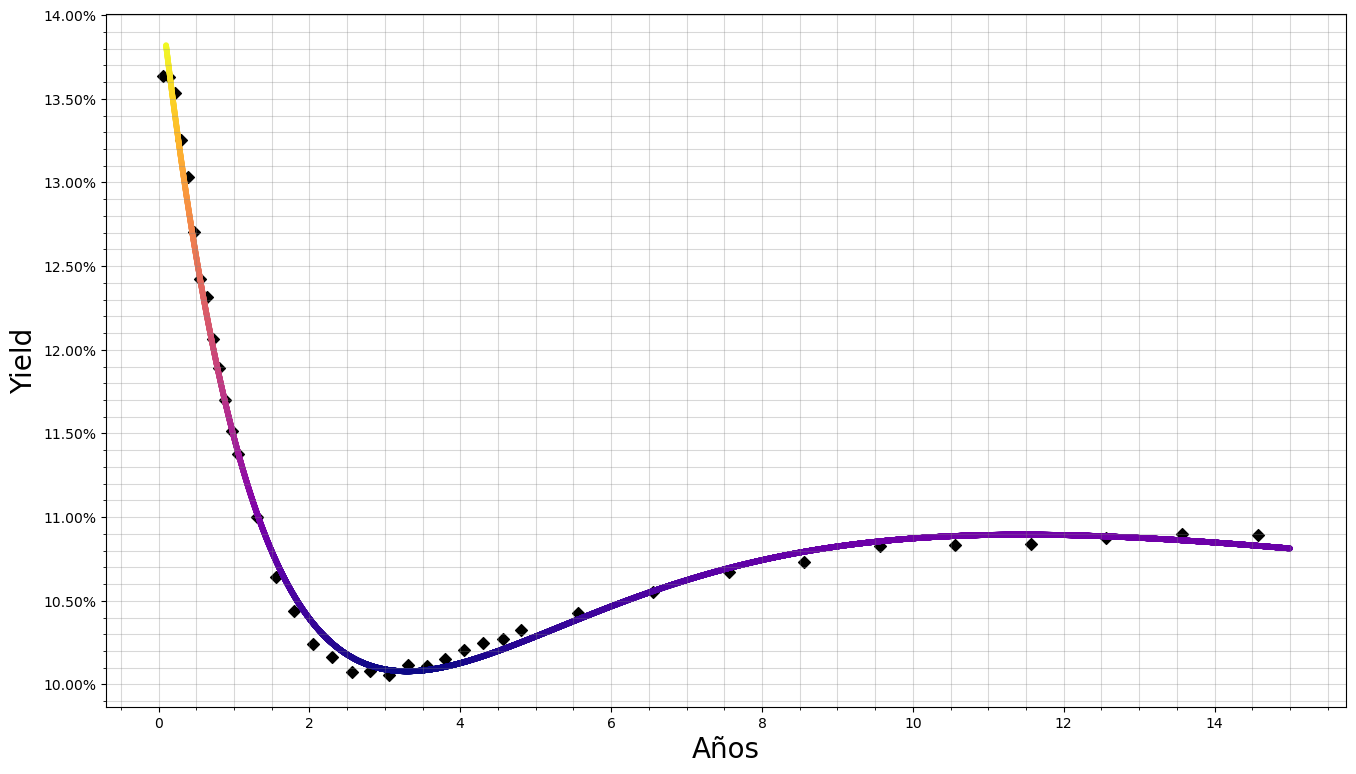

In [112]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
fig, ax = plt.subplots(figsize=(16,9))
ax.scatter(años_rest, Taxa_DI*100, marker = 'D', color='black')

ax.scatter(np.arange(0.1, 15, 0.001), interp*100, c=interp, cmap='plasma', s=10)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.xlabel('Años',fontsize=20)
plt.ylabel('Yield',fontsize=20)
plt.grid(which='major', axis='both',color='grey',alpha=0.3)
plt.minorticks_on()
plt.grid(which='minor', axis='both',color='grey',alpha=0.3)
print('Los coef. correspondidos a b1,..., lambda2 son : ',NSSMinimize(0.2,0.2,0.2,0.2,0.65,0.65,años_rest,Taxa_DI), 'y el error es de: ', NSSGoodFit(NSSMinimize(0.25,0.25,0.2,0.15,1,1,años_rest,Taxa_DI),años_rest,Taxa_DI))

In [6]:
index = np.argmin(np.abs(np.arange(0.1,15,0.001) - 7))

# extract the correspondin g y-value from `interp`
y = interp[index]
y

0.12507865964620088

In [14]:
from itertools import product
from functools import reduce

def argmin(f, seq):
   return reduce(lambda e1, e2: e1 if f(e1) <= f(e2) else e2, seq)


min_beta = 0.06
max_beta = 0.5
paso_chico_beta = 0.05
min_lambda = 0.3
max_lambda = 1.5
paso_chico_lambda = 0.05
beta0 = np.arange(min_beta, max_beta, paso_chico_beta)
beta1 = np.arange(min_beta, max_beta, paso_chico_beta)
beta2 = np.arange(min_beta, max_beta, paso_chico_beta)
beta3 = np.arange(min_beta, max_beta, paso_chico_beta)
lambda0 = np.arange(min_lambda, max_lambda, paso_chico_lambda)
lambda1 = np.arange(min_lambda, max_lambda, paso_chico_lambda)

best_x0 = argmin(lambda params: NSSGoodFit(params, años_rest,Taxa_DI_vec), product(beta0, beta1, beta2, beta3, lambda0, lambda1))
best_x0

(0.11, 0.06, 0.06, 0.06, 0.3, 1.4499999999999997)

In [17]:
(0.11, 0.06, 0.06, 0.06, 0.3, 1.4499999999999997)

(0.11, 0.06, 0.06, 0.06, 0.3, 1.4499999999999997)